# LCM Inference Demo: Multi-Engine Query Cost Prediction

This notebook demonstrates the complete inference workflow for the **Learned Cost Model (LCM)**—a GNN-based system that predicts query execution time and peak memory consumption across multiple database engines.

## System Overview

The LCM consists of:
1. **Plan Encoding**: Converts decorated Substrait query plans into heterogeneous graphs
2. **GNN Encoder**: Bottom-up message passing over the query plan graph 
3. **Multi-Head Predictor**: Per-engine prediction heads outputting (time, memory) estimates

## Workflow Steps
1. Load configuration and checkpoint
2. Build dataset from query plans and metrics
3. Create GNN dataset with encoder
4. Fit normalizer on training data
5. Build model architecture and load weights
6. Run inference and interpret predictions

## Step 0: Imports and Setup

In [1]:
import sys
import warnings
from pathlib import Path

# Ensure we're in the project root
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch

# CRITICAL: Set seed early for full reproducibility
# This ensures get_splits() shuffle and all other random ops match training
from flexdata_metric_prediction.utils.seed import set_global_seed
SEED = 76

set_global_seed(SEED)
print(f"Project root: {PROJECT_ROOT}")

print(f"Random seed: {SEED}")
print(f"PyTorch version: {torch.__version__}")

Project root: /Users/sgu/code/flexdata-metric-prediction
Random seed: 76
PyTorch version: 2.9.1


In [2]:
# Project imports - Dataset and Encoding
from flexdata_metric_prediction.dataset.dataset_builder import DatasetBuilder
from flexdata_metric_prediction.dataset.gnn_dataset import GNNDataset
from flexdata_metric_prediction.dataset.gnn_dataloader import GNNDataloader
from flexdata_metric_prediction.dataset.metric_normalizer import MetricNormalizer

# Project imports - Encoder
from flexdata_metric_prediction.encoder.hint_encoder import HintEncoder

# Project imports - Model
from flexdata_metric_prediction.model.bottom_up_gnn import MLP, BottomUpGNN
from flexdata_metric_prediction.model.multi_head_model import MultiHeadModel
from flexdata_metric_prediction.tree.tree_nodes import NODE_TYPES

# Project imports - Config
from flexdata_metric_prediction.utils.read_config import read_yaml_config

print("All modules imported successfully")

All modules imported successfully


## Step 1: Load Configuration

The configuration file specifies:
- Data paths (plans, metrics, queries)
- Engine configurations and metric mappings
- Model architecture parameters

In [3]:
# Paths (relative to project root)
CONFIG_PATH = PROJECT_ROOT / "config" / "test_multi_metric_big_model.yaml"
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints" / "best_model_sjsuz654.pt"

# Load configuration
config = read_yaml_config(str(CONFIG_PATH))

print(f"Experiment: {config['experiment']['name']}")
print(f"Dataset: {config['experiment']['dataset']}")

Experiment: Decreasing Qmean v5
Dataset: tpch_sf10


In [4]:
# Extract key configuration elements
data_config = config["data"]
model_config = config["model"]
training_config = config["training"]

# Get first schema (tpch in this case)
schema_name = list(data_config.keys())[0]
schema_config = data_config[schema_name]

print(f"Schema: {schema_name}")
print(f"\nEngines available:")
for engine in sorted(schema_config['labels_path'].keys()):
    print(f"  - {engine}")

print(f"\nMetrics per engine:")
for engine, metrics in schema_config['metrics'].items():
    print(f"  {engine}: {list(metrics.keys())} -> {list(metrics.values())}")

Schema: tpch

Engines available:
  - presto-w1
  - presto-w4
  - spark-w1
  - spark-w4

Metrics per engine:
  presto-w1: ['time', 'memory'] -> ['elapsedTime', 'peakNodeTotalMemory']
  presto-w4: ['time', 'memory'] -> ['elapsedTime', 'peakNodeTotalMemory']
  spark-w1: ['time', 'memory'] -> ['wall_clock_duration', 'on_heap_execution_memory']
  spark-w4: ['time', 'memory'] -> ['wall_clock_duration', 'on_heap_execution_memory']


## Step 2: Build Dataset

The `DatasetBuilder` loads:
- SQL queries from JSON file
- Substrait query plans from JSON files
- Execution metrics from CSV files (one per engine)

Each `QueryDatapoint` contains the SQL, plan, and multi-engine measurements.

In [5]:
# Build engine configurations from config
# Maps engine_name -> list of metric columns to extract from CSV
engine_configs = {
    engine: list(schema_config['metrics'][engine].values())
    for engine in schema_config['labels_path'].keys()
}

print("Engine configurations (engine -> CSV columns):")
for engine, cols in engine_configs.items():
    print(f"  {engine}: {cols}")

Engine configurations (engine -> CSV columns):
  presto-w1: ['elapsedTime', 'peakNodeTotalMemory']
  presto-w4: ['elapsedTime', 'peakNodeTotalMemory']
  spark-w1: ['wall_clock_duration', 'on_heap_execution_memory']
  spark-w4: ['wall_clock_duration', 'on_heap_execution_memory']


In [6]:
# Initialize DatasetBuilder
builder = DatasetBuilder(
    plans_dir=PROJECT_ROOT / schema_config['plan_path'],
    queries_file=PROJECT_ROOT / schema_config['queries_path'] / "selected_queries.json",
    metrics_dir=PROJECT_ROOT / "flexdata_metric_prediction" / "input_data_warehouse" / "processed_metrics",
    schema=schema_name,
)

# Build the QueryDataset
query_range = tuple(schema_config['query_range'])
query_dataset = builder.build_dataset(
    engine_configs=engine_configs,
    query_range=query_range,
    dataset_name=schema_name,
)

print(f"\nDataset built: {query_dataset}")
print(f"Query range: {query_range[0]} to {query_range[1]}")


Dataset built: tpch (2703 queries)
Query range: 1 to 3200


In [7]:
# Inspect a sample query
sample_query = query_dataset.queries[0]
print(f"Sample Query ID: {sample_query.id}")
print(f"SQL (first 200 chars): {sample_query.sql[:200] if sample_query.sql else 'N/A'}...")
print(f"Has plan: {sample_query.plan is not None}")
print(f"Has tree: {sample_query.tree is not None}")

# View available measurements for this query
print(f"\nMeasurements (ground truth):")
for engine, values in sample_query.measurements.items():
    print(f"  {engine}: {values}")

Sample Query ID: tpch_q1
SQL (first 200 chars): SELECT
    PS.PS_PARTKEY,
    N.N_NATIONKEY,
    N.N_NAME AS NATION_NAME,
    P.P_PARTKEY,
    P.P_RETAILPRICE,
    P.P_NAME AS PART_NAME,
    P.P_TYPE,
    P.P_CONTAINER,
    P.P_SIZE,
    P.P_MFGR,
...
Has plan: True
Has tree: False

Measurements (ground truth):
  presto-w4: {'elapsedTime': 121.2, 'peakNodeTotalMemory': 367.81}
  spark-w1: {'wall_clock_duration': 3.121, 'on_heap_execution_memory': 3264.0}
  spark-w4: {'wall_clock_duration': 3.38, 'on_heap_execution_memory': 864.0}


## Step 3: Create GNN Dataset with Encoder

The `HintEncoder` converts query plan trees into heterogeneous graphs:
- **Node types**: RelNode, OPNode, FieldNode, TableNode, LiteralNode
- **Features**: One-hot encoded operators/types + cardinality hints (log-normalized)

The `GNNDataset` wraps encoded graphs with multi-metric labels in **engine-major** order:
```
[presto-w1_time, presto-w1_memory, presto-w4_time, presto-w4_memory, spark-w1_time, ...]
```

In [8]:
# Create the encoder for converting plans to tree representations
encoder = HintEncoder(
    op_mapping=str(PROJECT_ROOT / "flexdata_metric_prediction" / "encoder" / "opMappingNew.json"),
    rel_mapping=str(PROJECT_ROOT / "flexdata_metric_prediction" / "encoder" / "relMapping.json"),
    type_mapping=str(PROJECT_ROOT / "flexdata_metric_prediction" / "encoder" / "typeMapping.json"),
)

print(f"Encoder created: {type(encoder).__name__}")
print(f"Op encoding length: {encoder.op_enc_length}")
print(f"Rel encoding length: {encoder.rel_enc_length}")
print(f"Type encoding length: {encoder.type_enc_length}")

Encoder created: HintEncoder
Op encoding length: 22
Rel encoding length: 8
Type encoding length: 7


In [9]:
# Build target_metrics mapping: engine -> [csv_column_names]
# IMPORTANT: Engines must be sorted alphabetically for consistent ordering
engines = sorted(schema_config['labels_path'].keys())
target_metrics = {
    engine: list(schema_config['metrics'][engine].values())
    for engine in engines
}

print("Target metrics (engine-major order):")
for engine in engines:
    print(f"  {engine}: {target_metrics[engine]}")

# Get semantic metric names (e.g., ['time', 'memory'])
semantic_names = list(schema_config['metrics'][engines[0]].keys())
print(f"\nSemantic metric names: {semantic_names}")

Target metrics (engine-major order):
  presto-w1: ['elapsedTime', 'peakNodeTotalMemory']
  presto-w4: ['elapsedTime', 'peakNodeTotalMemory']
  spark-w1: ['wall_clock_duration', 'on_heap_execution_memory']
  spark-w4: ['wall_clock_duration', 'on_heap_execution_memory']

Semantic metric names: ['time', 'memory']


In [10]:
# Create GNN Dataset (this encodes all query plans)
# This step takes ~10 seconds for large datasets
print("Creating GNN dataset (encoding query plans)...")

gnn_dataset = GNNDataset(
    datasets=[query_dataset],
    encoder=encoder,
    target_metrics=target_metrics,
    skip_on_error=True,  # Skip queries that fail encoding
)

print(f"\nGNN Dataset created")
print(f"Engines (sorted): {gnn_dataset.engines}")
print(f"Total graphs: {sum(len(gnn_dataset.data[d]) for d in gnn_dataset.data)}")

Creating GNN dataset (encoding query plans)...



GNN Dataset created
Engines (sorted): ['presto-w1', 'presto-w4', 'spark-w1', 'spark-w4']
Total graphs: 1960


In [11]:
# Inspect a sample GNN data object
sample_data = gnn_dataset.data[schema_name][0]
print(f"Sample HeteroData object:")
print(f"  Node types: {sample_data.node_types}")
print(f"  Edge types: {sample_data.edge_types}")
print(f"\nNode features (x):")
for ntype in sample_data.node_types:
    if hasattr(sample_data[ntype], 'x'):
        print(f"  {ntype}: shape {sample_data[ntype].x.shape}")

print(f"\nLabel shape (y): {sample_data.y.shape}")
print(f"Label values: {sample_data.y}")

Sample HeteroData object:
  Node types: ['TableNode', 'FieldNode', 'RelNode', 'OPNode', 'LiteralNode']
  Edge types: [('RelNode', 'edge', 'RelNode'), ('FieldNode', 'edge', 'RelNode'), ('OPNode', 'edge', 'RelNode'), ('TableNode', 'edge', 'FieldNode'), ('LiteralNode', 'edge', 'OPNode'), ('FieldNode', 'edge', 'OPNode'), ('OPNode', 'edge', 'OPNode')]

Node features (x):
  TableNode: shape torch.Size([3, 2])
  FieldNode: shape torch.Size([32, 11])
  RelNode: shape torch.Size([5, 10])
  OPNode: shape torch.Size([6, 22])
  LiteralNode: shape torch.Size([3, 9])

Label shape (y): torch.Size([1, 8])
Label values: tensor([[6.4200e+01, 1.1469e+03, 1.5990e+01, 4.3198e+02, 1.9160e+00, 0.0000e+00,
         9.4550e-01, 1.0887e+03]], dtype=torch.float64)


## Step 4: Create Train/Val/Test Splits and Fit Normalizer

The `MetricNormalizer` performs:
1. **Zero/negative imputation**: Replace with 5th percentile of positive values
2. **Log transformation**: `z = log(y + ε)`
3. **Z-score normalization**: `z_norm = (z - μ) / σ`

Statistics (μ, σ) are computed **only on training data** to prevent data leakage.

In [12]:
# Define split sizes from config
val_split = {schema_name: schema_config['num_val']}
test_split = {schema_name: schema_config['num_test']}

# Get splits (last N samples for val/test, remaining for train)
train_data, val_data, test_data = gnn_dataset.get_splits(val_split, test_split)

print(f"Data splits:")
print(f"  Train: {len(train_data)} samples")
print(f"  Val:   {len(val_data)} samples")
print(f"  Test:  {len(test_data)} samples")

Data splits:
  Train: 1568 samples
  Val:   196 samples
  Test:  196 samples


In [13]:
# Extract raw labels from training data for normalizer fitting
def extract_labels(data_list):
    """Extract labels as numpy array [n_samples, n_labels]"""
    return np.stack([data.y.squeeze().numpy() for data in data_list], axis=0)

train_labels_raw = extract_labels(train_data)
print(f"Raw training labels shape: {train_labels_raw.shape}")
print(f"Raw label range: [{np.nanmin(train_labels_raw):.2f}, {np.nanmax(train_labels_raw):.2f}]")

Raw training labels shape: (1568, 8)
Raw label range: [0.00, 10432.00]


In [14]:
# Fit MetricNormalizer on training data
normalizer = MetricNormalizer(impute_percentile=5.0)
normalizer.fit(train_labels_raw, engines, semantic_names)

print("\n" + normalizer.summary())


MetricNormalizer Statistics:
  Engines: ['presto-w1', 'presto-w4', 'spark-w1', 'spark-w4']
  Metrics: ['time', 'memory']
  Impute percentile: p5.0

  presto-w1/memory:
    μ=5.1884, σ=1.4139
    impute=28.6720, n=1568, n_imputed=31
  presto-w1/time:
    μ=2.3282, σ=1.4639
    impute=0.7317, n=1568, n_imputed=0
  presto-w4/memory:
    μ=4.5759, σ=1.1303
    impute=20.7680, n=1568, n_imputed=31
  presto-w4/time:
    μ=1.8062, σ=1.1637
    impute=0.9789, n=1568, n_imputed=0
  spark-w1/memory:
    μ=7.0938, σ=1.5885
    impute=64.5000, n=1568, n_imputed=180
  spark-w1/time:
    μ=1.2882, σ=1.0201
    impute=0.5837, n=1568, n_imputed=0
  spark-w4/memory:
    μ=5.7243, σ=1.5899
    impute=16.5000, n=1568, n_imputed=151
  spark-w4/time:
    μ=1.3028, σ=1.1310
    impute=0.5241, n=1568, n_imputed=0


In [15]:
# Apply normalization to all splits (in-place)
def apply_normalization(data_list, normalizer):
    """Apply normalizer to labels in data list (in-place)"""
    for data in data_list:
        y_np = data.y.numpy()
        y_norm = normalizer.transform(y_np)
        data.y = torch.from_numpy(y_norm).to(data.y.dtype)
    return data_list

train_data = apply_normalization(train_data, normalizer)
val_data = apply_normalization(val_data, normalizer)
test_data = apply_normalization(test_data, normalizer)

# Verify normalization
train_labels_norm = extract_labels(train_data)
print(f"Normalized label range: [{np.nanmin(train_labels_norm):.2f}, {np.nanmax(train_labels_norm):.2f}]")
print(f"Mean: {np.nanmean(train_labels_norm):.4f}, Std: {np.nanstd(train_labels_norm):.4f}")

Normalized label range: [-4.90, 3.36]
Mean: -0.0000, Std: 1.0000


## Step 5: Build Model Architecture

The model consists of:
1. **BottomUpGNN**: Heterogeneous GNN with type-specific MLPs for node projection and message passing
2. **MultiHeadModel**: Wrapper that adds per-engine prediction heads

Input dimensions are inferred from the training data.

In [16]:
# Infer input dimensions from training data
# Scan batches to find feature dimensions per node type
input_dims = {}
train_loader = GNNDataloader(train_data, batch_size=32, shuffle=False)

for batch in train_loader:
    # Iterate over node types present in this batch
    for node_type_str in batch.node_types: # e.g., "RelNode", "OPNode", ...
        if hasattr(batch[node_type_str], "x"):
            dim = batch[node_type_str].x.shape[1] # Feature dimension
            input_dims[node_type_str] = max(input_dims.get(node_type_str, 0), dim)  # Track max seen

# Set default dimension for missing node types (required by the model)
for nodeClass in NODE_TYPES:
    if nodeClass.__name__ not in input_dims:
        input_dims[nodeClass.__name__] = 1

print("Inferred input dimensions per node type:")
for ntype, dim in sorted(input_dims.items()):
    print(f"  {ntype}: {dim}")

Inferred input dimensions per node type:
  FieldNode: 11
  LiteralNode: 9
  OPNode: 22
  RelNode: 10
  TableNode: 2


In [17]:
# Build the GNN encoder
encoder_model = BottomUpGNN(input_dims, model_config)

print(f"GNN Encoder created: {type(encoder_model).__name__}")
print(f"Hidden dimension: {model_config['hidden_mlp']['output_dim']}")
print(f"Mean pooling: {model_config.get('mean_pool', False)}")

GNN Encoder created: BottomUpGNN
Hidden dimension: 144
Mean pooling: True


In [18]:
# Create MultiHeadModel and add per-engine prediction heads
model = MultiHeadModel(encoder_model=encoder_model)

# Number of output metrics per engine
num_metrics = len(semantic_names)  # e.g., 2 for [time, memory]

# Register a prediction head for each engine
for engine in engines:
    head_config = model_config['head'].copy()
    head_config['output_dim'] = num_metrics  # Override to match actual metrics
    
    head = MLP(
        input_dim=model_config['final_mlp']['output_dim'],
        mlp_config=head_config,
    )
    model.register_head(engine, head, dtype=torch.float64)
    print(f"  Registered head for {engine}: output_dim={num_metrics}")

# Convert model to float64 (match training)
model = model.double()

print(f"\nMultiHeadModel created with {len(engines)} prediction heads")

  Registered head for presto-w1: output_dim=2
  Registered head for presto-w4: output_dim=2
  Registered head for spark-w1: output_dim=2
  Registered head for spark-w4: output_dim=2

MultiHeadModel created with 4 prediction heads


In [19]:
# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameter count:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Model parameter count:
  Total: 863,824
  Trainable: 863,824


## Step 6: Load Checkpoint

Load the trained model weights from the checkpoint file.

In [20]:
# Load checkpoint
checkpoint_path = PROJECT_ROOT / "checkpoints" / config.get("checkpoint_path", config.get("checkpoint", "best_model_sjsuz654.pt"))
if isinstance(checkpoint_path, str) and not checkpoint_path.startswith("/"):
    checkpoint_path = PROJECT_ROOT / checkpoint_path
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

print(f"Checkpoint loaded from: {checkpoint_path}")
print(f"Checkpoint keys: {list(checkpoint.keys())}")
print(f"Trained for: {checkpoint['epoch']} epochs")

Checkpoint loaded from: /Users/sgu/code/flexdata-metric-prediction/checkpoints/best_model_sjsuz654.pt
Checkpoint keys: ['epoch', 'model_state_dict', 'metric_value', 'metric_name', 'optimizer_state_dict', 'metadata']
Trained for: 127 epochs


In [21]:
# Load state dict and convert model to double precision (float64) to match training
model.load_state_dict(checkpoint["model_state_dict"])
model = model.double()  # IMPORTANT: Training uses float64
model.eval()

print("Model weights loaded successfully")
print("Model converted to float64 precision")

Model weights loaded successfully
Model converted to float64 precision


## Step 7: Run Inference

The model outputs predictions in **normalized log-space**. We need to:
1. Run forward pass to get predictions
2. Apply inverse normalization to get raw-scale predictions

Output layout (engine-major, flattened):
```
[presto-w1_time, presto-w1_memory, presto-w4_time, presto-w4_memory, spark-w1_time, spark-w1_memory, spark-w4_time, spark-w4_memory]
```

In [22]:
# Create test dataloader
test_loader = GNNDataloader(test_data, batch_size=64, shuffle=False)

print(f"Test set: {len(test_data)} samples")
print(f"Batch size: 64")

Test set: 196 samples
Batch size: 64


In [23]:
# Run inference on test set
all_preds_norm = []
all_labels_norm = []
all_query_ids = []

with torch.no_grad():
    for batch in test_loader:
        # Forward pass: returns dict {engine: [batch, num_metrics]}
        preds_dict = model.predict_engines(batch)
        
        # Stack predictions in engine-major order: [batch, n_engines * n_metrics]
        preds_norm = torch.cat([preds_dict[e] for e in engines], dim=1)
        
        all_preds_norm.append(preds_norm.numpy())
        all_labels_norm.append(batch.y.numpy())
        
        # Collect query IDs if available
        if hasattr(batch, 'query_id'):
            all_query_ids.extend(batch.query_id)

# Concatenate all batches
preds_norm = np.vstack(all_preds_norm)
labels_norm = np.vstack(all_labels_norm)

print(f"Predictions (normalized): shape {preds_norm.shape}")
print(f"Labels (normalized): shape {labels_norm.shape}")

Predictions (normalized): shape (196, 8)
Labels (normalized): shape (196, 8)


In [24]:
# Apply inverse transform to get raw-scale predictions
preds_raw = normalizer.inverse_transform(preds_norm)
labels_raw = normalizer.inverse_transform(labels_norm)

print(f"Predictions (raw scale):")
print(f"  Time range: [{np.nanmin(preds_raw[:, 0::2]):.2f}, {np.nanmax(preds_raw[:, 0::2]):.2f}] seconds")
print(f"  Memory range: [{np.nanmin(preds_raw[:, 1::2]):.2f}, {np.nanmax(preds_raw[:, 1::2]):.2f}] MB")

Predictions (raw scale):
  Time range: [0.02, 150.61] seconds
  Memory range: [2.85, 8464.24] MB


## Step 8: Interpret Predictions

The flattened output vector follows **engine-major order**:
- Index `e * num_metrics + 0` = time for engine `e`
- Index `e * num_metrics + 1` = memory for engine `e`

In [25]:
# Parse predictions into a structured DataFrame
results = []
num_metrics = len(semantic_names)

for i in range(len(preds_raw)):
    query_id = all_query_ids[i] if all_query_ids else f"q_{i}"
    
    for e_idx, engine in enumerate(engines):
        # Extract time and memory for this engine
        time_idx = e_idx * num_metrics + 0
        mem_idx = e_idx * num_metrics + 1
        
        results.append({
            'query_id': query_id,
            'engine': engine,
            'pred_time': preds_raw[i, time_idx],
            'pred_memory': preds_raw[i, mem_idx],
            'true_time': labels_raw[i, time_idx],
            'true_memory': labels_raw[i, mem_idx],
        })

results_df = pd.DataFrame(results)
print(f"Results DataFrame shape: {results_df.shape}")
results_df.head(8)

Results DataFrame shape: (784, 6)


,query_id,engine,pred_time,pred_memory,true_time,true_memory
0,tpch_q2291,presto-w1,1.970577,29.346280,2.630,183.92
1,tpch_q2291,presto-w4,2.515779,19.338719,2.620,109.78
2,tpch_q2291,spark-w1,3.132408,677.852003,2.637,2368.00
3,tpch_q2291,spark-w4,3.080230,480.193359,2.210,676.00
4,tpch_q1752,presto-w1,36.581540,140.941181,33.280,142.84
5,tpch_q1752,presto-w4,17.220842,75.839302,17.930,92.41
6,tpch_q1752,spark-w1,6.733274,3342.477413,6.897,3139.00
7,tpch_q1752,spark-w4,6.693432,846.006578,6.824,786.00


In [26]:
# Compute Q-error (max(pred/true, true/pred)) per metric
def q_error(pred, true):
    """Compute Q-error, handling NaN values"""
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.maximum(pred / true, true / pred)
    return ratio

results_df['qerror_time'] = q_error(results_df['pred_time'], results_df['true_time'])
results_df['qerror_memory'] = q_error(results_df['pred_memory'], results_df['true_memory'])

# Summary statistics per engine
print("Q-Error Summary by Engine:")
print("=" * 70)
summary = results_df.groupby('engine').agg({
    'qerror_time': ['median', 'mean', lambda x: np.nanpercentile(x, 95)],
    'qerror_memory': ['median', 'mean', lambda x: np.nanpercentile(x, 95)],
}).round(3)
summary.columns = ['Time_Median', 'Time_Mean', 'Time_P95', 'Mem_Median', 'Mem_Mean', 'Mem_P95']
print(summary)

Q-Error Summary by Engine:
           Time_Median  Time_Mean  Time_P95  Mem_Median  Mem_Mean  Mem_P95
engine                                                                    
presto-w1        1.274      1.954     4.554       1.309     2.353    6.684
presto-w4        1.237      1.898     3.592       1.311     1.974    5.298
spark-w1         1.202      2.131     4.651       1.243     3.293   11.397
spark-w4         1.201      2.350     5.912       1.265     3.553   17.836


In [ ]:
# KEY DIAGNOSTIC: Compare normalizer stats
# The training may save normalizer stats in the checkpoint. If you're fitting a new one,
# the μ/σ could differ slightly → different inverse transforms → different Q-errors

print("=" * 70)
print("NORMALIZER COMPARISON")
print("=" * 70)
print(f"Checkpoint keys: {list(checkpoint.keys())}")

# Check if checkpoint has normalizer stats
if 'normalizer_stats' in checkpoint:
    print("\n✓ Checkpoint contains normalizer stats!")
    print("\nComparing checkpoint vs notebook-fitted normalizer:")
    ckpt_stats = checkpoint['normalizer_stats']
    
    for key in sorted(normalizer.stats.keys()):
        engine, metric = key
        notebook_mean = normalizer.stats[key].mean
        notebook_std = normalizer.stats[key].std
        
        ckpt_key = f"{engine}/{metric}"
        if ckpt_key in ckpt_stats:
            ckpt_mean = ckpt_stats[ckpt_key]['mean']
            ckpt_std = ckpt_stats[ckpt_key]['std']
            
            mean_diff = abs(notebook_mean - ckpt_mean)
            std_diff = abs(notebook_std - ckpt_std)
            
            status = "✓" if mean_diff < 1e-6 and std_diff < 1e-6 else "✗ MISMATCH"
            print(f"  {engine}/{metric}: {status}")
            if mean_diff >= 1e-6 or std_diff >= 1e-6:
                print(f"    mean: notebook={notebook_mean:.6f}, ckpt={ckpt_mean:.6f}, diff={mean_diff:.2e}")
                print(f"    std:  notebook={notebook_std:.6f}, ckpt={ckpt_std:.6f}, diff={std_diff:.2e}")
else:
    print("\n✗ Checkpoint does NOT contain normalizer stats!")
    print("  → You're fitting a NEW normalizer on the (re-shuffled) training data")
    print("  → This causes different μ/σ → different inverse transforms → different Q-errors")
    print("\n  FIX OPTIONS:")
    print("  1. Save normalizer stats to checkpoint during training")
    print("  2. Load normalizer from checkpoint instead of re-fitting")

## Step 9: Visualize Results

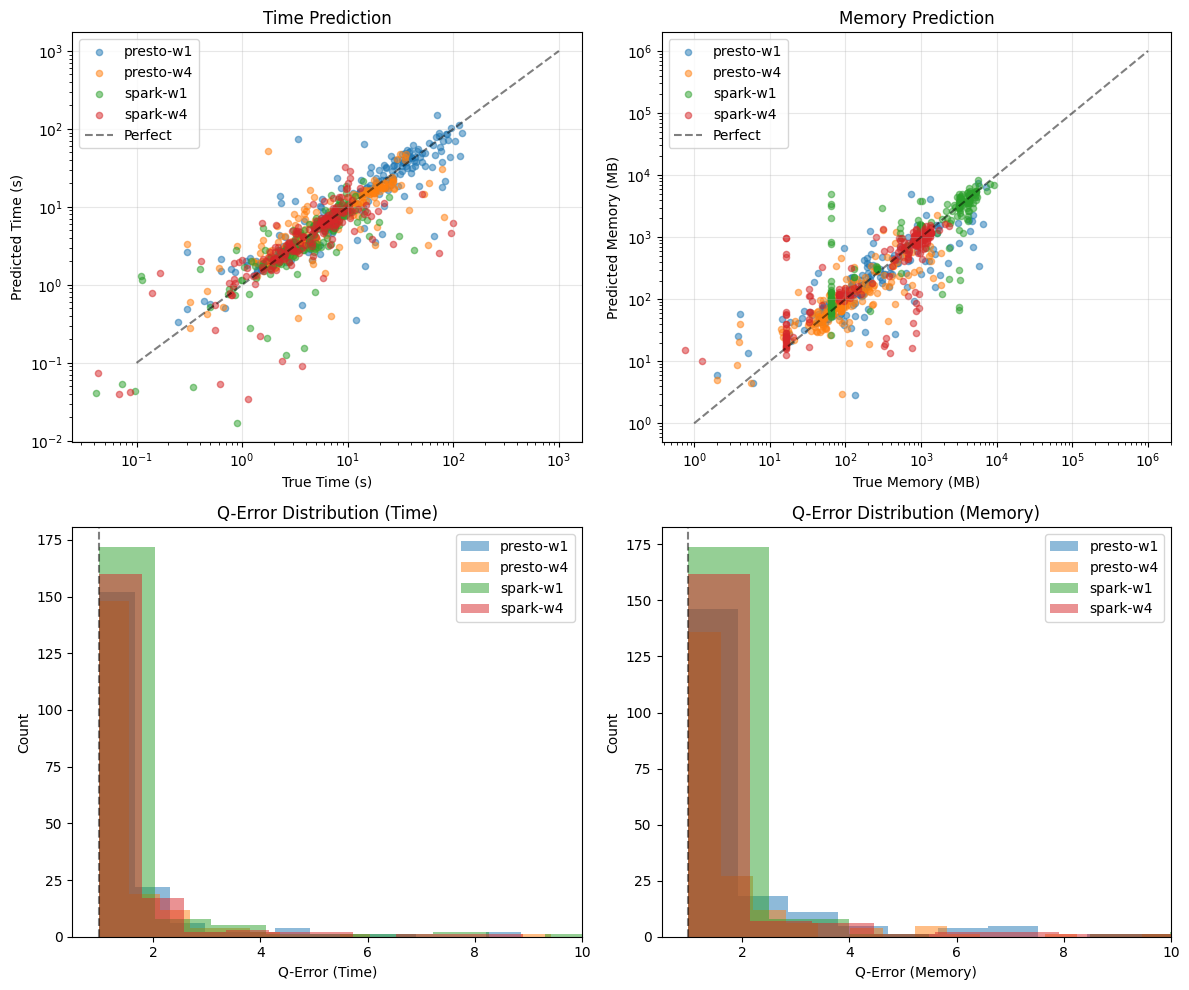

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Predicted vs True Time (all engines)
ax1 = axes[0, 0]
for engine in engines:
    mask = results_df['engine'] == engine
    ax1.scatter(
        results_df.loc[mask, 'true_time'], 
        results_df.loc[mask, 'pred_time'],
        alpha=0.5, s=20, label=engine
    )
ax1.plot([0.1, 1000], [0.1, 1000], 'k--', alpha=0.5, label='Perfect')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('True Time (s)')
ax1.set_ylabel('Predicted Time (s)')
ax1.set_title('Time Prediction')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs True Memory (all engines)
ax2 = axes[0, 1]
for engine in engines:
    mask = results_df['engine'] == engine
    ax2.scatter(
        results_df.loc[mask, 'true_memory'], 
        results_df.loc[mask, 'pred_memory'],
        alpha=0.5, s=20, label=engine
    )
ax2.plot([1, 1e6], [1, 1e6], 'k--', alpha=0.5, label='Perfect')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('True Memory (MB)')
ax2.set_ylabel('Predicted Memory (MB)')
ax2.set_title('Memory Prediction')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Q-Error distribution for Time
ax3 = axes[1, 0]
for engine in engines:
    mask = results_df['engine'] == engine
    qerrors = results_df.loc[mask, 'qerror_time'].dropna()
    ax3.hist(qerrors, bins=50, alpha=0.5, label=engine)
ax3.axvline(x=1, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Q-Error (Time)')
ax3.set_ylabel('Count')
ax3.set_title('Q-Error Distribution (Time)')
ax3.legend()
ax3.set_xlim(0.5, 10)

# Plot 4: Q-Error distribution for Memory
ax4 = axes[1, 1]
for engine in engines:
    mask = results_df['engine'] == engine
    qerrors = results_df.loc[mask, 'qerror_memory'].dropna()
    ax4.hist(qerrors, bins=50, alpha=0.5, label=engine)
ax4.axvline(x=1, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Q-Error (Memory)')
ax4.set_ylabel('Count')
ax4.set_title('Q-Error Distribution (Memory)')
ax4.legend()
ax4.set_xlim(0.5, 10)

plt.tight_layout()
plt.show()

## Step 10: Single Query Inference Example

**Note:** The GNN modifies node features in-place during forward pass. After running batch inference (Step 7), the test_data objects have already been modified. To run single-query inference, either:
1. Restart the kernel and run all cells fresh
2. Re-create the GNN dataset (Step 3)

The function below demonstrates how to run inference on a single query:

In [28]:
# NOTE: This cell may fail if you've already run batch inference (Step 7)
# because the GNN modifies node features in-place.
# Restart the kernel and run from the beginning to use this.

def predict_single_query(model, query_idx, gnn_dataset, normalizer, engines, semantic_names, val_split, test_split):
    """
    Run inference on a single query - creates fresh data to avoid in-place modification issues.
    
    Args:
        model: Trained MultiHeadModel
        query_idx: Index in test_data  
        gnn_dataset: The GNNDataset object (to get fresh splits)
        normalizer: Fitted MetricNormalizer
        engines: List of engine names (sorted)
        semantic_names: List of metric names (e.g., ['time', 'memory'])
        val_split, test_split: Split configs
    
    Returns:
        Dict mapping engine -> {metric: predicted_value}
    """
    model.eval()
    num_metrics = len(semantic_names)
    
    # Get fresh data splits
    _, _, fresh_test_data = gnn_dataset.get_splits(val_split, test_split)
    
    # Get the specific query
    data = fresh_test_data[query_idx]
    
    # Create a mini-batch
    mini_loader = GNNDataloader([data], batch_size=1, shuffle=False)
    batched_data = next(iter(mini_loader))
    
    with torch.no_grad():
        preds_dict = model.predict_engines(batched_data)
        preds_norm = torch.cat([preds_dict[e] for e in engines], dim=1)
        preds_raw = normalizer.inverse_transform(preds_norm.numpy())
    
    # Parse into structured output
    result = {}
    for e_idx, engine in enumerate(engines):
        result[engine] = {}
        for m_idx, metric in enumerate(semantic_names):
            col_idx = e_idx * num_metrics + m_idx
            result[engine][metric] = float(preds_raw[0, col_idx])
    
    return result, data.y.numpy()


# # Uncomment and run this after restarting kernel:
# sample_idx = 20
# predictions, gt_norm = predict_single_query(
#     model, sample_idx, gnn_dataset, normalizer, engines, semantic_names, val_split, test_split
# )
# gt_raw = normalizer.inverse_transform(gt_norm.reshape(1, -1))

# print(f"Single Query Inference (Test Sample #{sample_idx})")
# print("=" * 60)
# for e_idx, (engine, metrics) in enumerate(predictions.items()):
#     gt_time = gt_raw[0, e_idx * 2]
#     gt_mem = gt_raw[0, e_idx * 2 + 1]
#     print(f"\n{engine}:")
#     print(f"  Time:   Predicted={metrics['time']:.2f}s,  Actual={gt_time:.2f}s")
#     print(f"  Memory: Predicted={metrics['memory']:.2f}MB, Actual={gt_mem:.2f}MB")

# print(" Single query inference function defined")
# print("  Uncomment the example code above to test (requires fresh kernel)")

## Summary

This notebook demonstrated the complete LCM (Learned Cost Model) inference workflow:

1. **Load Configuration**: Read YAML config defining data paths, engine configs, and model architecture
2. **Build Dataset**: Use `DatasetBuilder` to load SQL, plans, and metrics from files
3. **Create GNN Dataset**: Use `HintEncoder` to convert Substrait plans to heterogeneous graphs
4. **Fit Normalizer**: Compute μ/σ statistics from training data for log-z-score normalization
5. **Build Model**: Create `BottomUpGNN` encoder + per-engine `MultiHeadModel` prediction heads
6. **Load Checkpoint**: Load trained weights from `.pt` file
7. **Run Inference**: Forward pass → inverse normalization → raw predictions
8. **Interpret Output**: Parse flattened engine-major output into structured predictions
9. **Visualize**: Scatter plots and Q-error distributions

### Key Concepts

**Output Vector Layout** (engine-major order):
```
[e0_time, e0_memory, e1_time, e1_memory, e2_time, e2_memory, e3_time, e3_memory]
  └─ presto-w1 ─┘   └─ presto-w4 ─┘    └── spark-w1 ──┘    └── spark-w4 ──┘
```

**Normalization Pipeline**:
1. Log transform → `log(y + ε)`  
2. Z-score → `(log_y - μ) / σ`

### Important Notes

- The GNN modifies node features **in-place** during forward pass
- For repeated inference, restart kernel or re-create dataset
- Model expects **float64** precision (call `model.double()`)
- Batch inference is recommended for efficiency